<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Tree-Ensembles/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
# Install dependencies.
!pip install category_encoders

In [0]:
# General imports.
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns

# Scikit-learn imports.
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.utils.multiclass import unique_labels

In [0]:
# Load data.
url = ('https://drive.google.com/uc?export=download'
       '&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX')
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

## Overview

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

### Part 1. Prepare to model

#### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

#### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

### Part 2. Evaluate models

#### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


#### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

## Part 1.  Prepare to model

### Required

#### 1. Do train/validate/test split

Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.

In [0]:
# Move game date from index position to column.
df = df.reset_index()

In [0]:
# Split training, validation, and testing sets. There should be no games from 
# July through September, so split dates anywhere in that range should work 
# equivalently.
train = df[df['game_date'] <= '2017-09-01']
val = df[df['game_date'].between('2017-09-01', '2018-09-01')]
test = df[df['game_date'] >= '2018-09-01']

In [6]:
# Check dataset dimensions.
train.shape, val.shape, test.shape

((11081, 20), (1168, 20), (1709, 20))

#### 2. Begin with baselines for classification

Your target to predict is shot_made_flag. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?

In [0]:
# Split datasets into target vectors and feature matrices.
target = 'shot_made_flag'

y_train = train[target]
y_val = val[target]
y_test = test[target]

X_train = train.drop(columns=[target])
X_val = val.drop(columns=[target])
X_test = test.drop(columns=[target])

In [8]:
# Find majority class.
y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

In [0]:
# Make predictions on validation set.
y_pred = np.full_like(y_val, y_train.mode())

In [10]:
# Evaluate predictions on validation set.
accuracy_score(y_val, y_pred)

0.5162671232876712

#### 3. Use ordinal encoding or one-hot encoding

In [11]:
# Preview sample data.
X_train.sample(random_state=0, n=5)

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot
3725,2013-04-03,21201122,59,Stephen Curry,1,6,43,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,211,137,GSW,NOH,Regular Season,-1.0
651,2010-02-17,20900800,284,Stephen Curry,3,11,0,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,124,124,GSW,SAC,Regular Season,29.0
4443,2013-12-09,21300304,417,Stephen Curry,3,0,0,Driving Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,-38,15,CHA,GSW,Regular Season,-8.0
5415,2014-04-10,21301175,290,Stephen Curry,3,9,52,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,114,244,GSW,DEN,Regular Season,7.0
3941,2013-04-28,41200164,234,Stephen Curry,2,3,55,Floating Jump shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,-16,31,GSW,DEN,Playoffs,3.0


In [12]:
# Check for null values.
X_train.isnull().sum()

game_date                  0
game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [13]:
# Explore potential numeric features.
X_train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
game_id,11081.0,2.390649e+07,6.772101e+06,20900015.0,21200272.0,21400275.0,21600099.0,41600405.0
game_event_id,11081.0,2.566610e+02,1.604073e+02,2.0,102.0,263.0,377.0,703.0
period,11081.0,2.423518e+00,1.131651e+00,1.0,1.0,2.0,3.0,6.0
minutes_remaining,11081.0,4.765454e+00,3.334664e+00,0.0,2.0,5.0,7.0,11.0
seconds_remaining,11081.0,2.851277e+01,1.757202e+01,0.0,13.0,29.0,43.0,59.0
shot_distance,11081.0,1.729005e+01,1.018772e+01,0.0,8.0,21.0,25.0,83.0
loc_x,11081.0,8.112986e-02,1.230886e+02,-250.0,-92.0,1.0,94.0,247.0
loc_y,11081.0,1.287665e+02,1.013382e+02,-41.0,23.0,138.0,214.0,811.0
scoremargin_before_shot,11081.0,1.427940e+00,1.020311e+01,-39.0,-5.0,1.0,8.0,43.0


In [14]:
# Explore correlations between numeric features and target.
train.corr().sort_values(target)

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
shot_distance,0.023785,-0.002890,-0.016104,-0.048457,-0.065372,1.000000,-0.016984,0.822021,-0.130672,0.021880
loc_y,0.018698,0.019620,0.002621,-0.071711,-0.069923,0.822021,0.031427,1.000000,-0.128068,0.024187
game_event_id,0.033402,1.000000,0.959205,-0.305079,-0.026451,-0.002890,0.045370,0.019620,-0.016233,0.069178
game_id,1.000000,0.033402,0.011489,-0.037475,-0.009470,0.023785,-0.002332,0.018698,-0.014778,-0.013198
period,0.011489,0.959205,1.000000,-0.084455,0.005109,-0.016104,0.045734,0.002621,-0.006359,0.058317
loc_x,-0.002332,0.045370,0.045734,-0.016741,-0.012759,-0.016984,1.000000,0.031427,-0.006177,0.016386
scoremargin_before_shot,-0.013198,0.069178,0.058317,-0.085324,-0.008467,0.021880,0.016386,0.024187,-0.001470,1.000000
seconds_remaining,-0.009470,-0.026451,0.005109,0.044292,1.000000,-0.065372,-0.012759,-0.069923,0.029952,-0.008467
minutes_remaining,-0.037475,-0.305079,-0.084455,1.000000,0.044292,-0.048457,-0.016741,-0.071711,0.039235,-0.085324
shot_made_flag,-0.014778,-0.016233,-0.006359,0.039235,0.029952,-0.130672,-0.006177,-0.128068,1.000000,-0.001470


In [15]:
# Explore potential categorical and other features.
X_train.describe(exclude='number').T

,count,unique,top,freq,first,last
game_date,11081,647,2013-05-06 00:00:00,35,2009-10-28 00:00:00,2017-06-12 00:00:00
player_name,11081,1,Stephen Curry,11081,NaN,NaN
action_type,11081,51,Jump Shot,5375,NaN,NaN
shot_type,11081,2,2PT Field Goal,5941,NaN,NaN
shot_zone_basic,11081,7,Above the Break 3,4298,NaN,NaN
shot_zone_area,11081,6,Center(C),4820,NaN,NaN
shot_zone_range,11081,5,24+ ft.,5065,NaN,NaN
htm,11081,32,GSW,5512,NaN,NaN
vtm,11081,32,GSW,5569,NaN,NaN
season_type,11081,2,Regular Season,9642,NaN,NaN


In [0]:
# Select a numeric and a categorical feature.
features = ['minutes_remaining', 'shot_zone_range']

In [17]:
# Select a categorical feature and examine it.
X_train.shot_zone_range.value_counts()

24+ ft.            5065
Less Than 8 ft.    2711
16-24 ft.          2133
8-16 ft.           1097
Back Court Shot      75
Name: shot_zone_range, dtype: int64

In [0]:
# Define sensible mapping. This isn't strictly necessary for decision trees,
# but it is important for logistic regression.
ordinal_cols_mapping = [{
    'col': 'shot_zone_range',
    'mapping': {
        'Back Court Shot': 4,
        '24+ ft.': 3,
        '16-24 ft.': 2,
        '8-16 ft.': 1,
        'Less Than 8 ft.': 0,
    }},
]

In [0]:
# Instantiate and configure ordinal encoder.
encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)

In [0]:
# Encode training and validation data.
X_train_encoded = encoder.fit_transform(X_train[features])
X_val_encoded = encoder.transform(X_val[features])

#### 4. Scale data

In [0]:
# Instantiate and configure scaler.
scaler = RobustScaler()

In [0]:
# Scale training and validation data.
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

#### 5. Train a random forest or logistic regression classifier

In [0]:
# Instantiate and configure model.
lr_model = LogisticRegression(solver='lbfgs')

In [24]:
# Fit model.
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Stretch goals

Feature Engineer

#### 1. Homecourt Advantage

Is the home team (htm) the Golden State Warriors (GSW)?

In [0]:
def homecourt_advantage(X):
  """
  Defines a boolean feature indicating whether the home team is the Golden 
  State Warriors.
  """
  X = X.copy()
  X['homecourt_advantage'] = X['htm'] == 'GSW'
  return X

#### 2. Opponent

Who is the other team playing the Golden State Warriors?

In [0]:
def opponent(X):
  """
  Defines a categorical (string) feature identifying the opposing (non-GSW) 
  team.
  """
  X = X.copy()
  X['opponent'] = X['homecourt_advantage'] * X['vtm'] + \
                  ~X['homecourt_advantage'] * X['htm']
  return X

#### 3. Seconds remaining in the period

Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.

In [0]:
def seconds_in_period(X):
  """
  Defines a numeric feature giving the total number of seconds remaining in the 
  current period.
  """
  X = X.copy()
  X['seconds_in_period'] = pd.to_timedelta(X['minutes_remaining'], 'm') + \
                           pd.to_timedelta(X['seconds_remaining'], 's')
  X['seconds_in_period'] = X['seconds_in_period'].dt.total_seconds()
  X = X.drop(columns=['minutes_remaining', 'seconds_remaining'])
  return X

#### 4. Seconds remaining in the game

Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.

In [0]:
def seconds_in_game(X):
  """
  Defines a numeric feature giving the total number of seconds remaining in the 
  game.
  """
  X = X.copy()
  X['seconds_in_game'] = (4 - X['period']) * pd.to_timedelta(12, 'm') + \
                         pd.to_timedelta(X['seconds_in_period'], 's')
  X['seconds_in_game'] = X['seconds_in_game'].dt.total_seconds()
  return X

#### 5. Made previous shot

Was Steph Curry's previous shot successful?

In [0]:
def made_previous_shot(X, y):
  """
  Define boolean feature indicating success or failure of previous shot.
  """
  X = X.copy()
  
  # Store shot outcomes for all three datasets.
  made_previous_shot = y
  
  # Re-index to map data from previous row (shot) to next.
  made_previous_shot.index += 1
  
  # Insert a 0 for the first shot of the 2009/2010 season. Really, it's 
  # arguable what this feature means for the first shot of any game, nevermind 
  # of a season, but it's a sprint challenge and we're not going to worry about 
  # it.
  made_previous_shot = pd.concat([pd.Series([0]), made_previous_shot])
  
  # Name the series; this will be the name of the new column.
  made_previous_shot = made_previous_shot.rename('made_previous_shot')
  
  # Merge on index to match everything up nicely.
  X = X.join(made_previous_shot)
  
  return X

### Wrangle data

In [30]:
X_train.head()

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot
0,2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,GSW,HOU,Regular Season,2.0
1,2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,GSW,HOU,Regular Season,0.0
2,2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,GSW,HOU,Regular Season,-4.0
3,2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,GSW,HOU,Regular Season,-4.0
4,2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,GSW,HOU,Regular Season,0.0


In [0]:
def wrangle(X, y):
  X = X.copy()
  
  # Add date features.
  X['game_year'] = X['game_date'].dt.year
  X['game_month'] = X['game_date'].dt.month
  X['game_day'] = X['game_date'].dt.day
  X['game_weekday'] = X['game_date'].dt.weekday
  
  # Add homecourt_advantage feature.
  X = homecourt_advantage(X)
  
  # Add opponent feature.
  X = opponent(X)
  
  # Add seconds_in_period feature.
  X = seconds_in_period(X)
  
  # Add seconds_in_game feature.
  X = seconds_in_game(X)
  
  # Add made_previous_shot_feature.
  X = made_previous_shot(X, y)
  
  # Drop irrelevant and redundant columns.
  X = X.drop(columns = ['game_id', 
                        'game_date',
                        'game_event_id', 
                        'player_name', 
                        'period', 
                        'shot_zone_range',
                        'shot_distance',
                        'htm', 
                        'vtm'])
  
  return(X)

In [0]:
# Follow the same data wrangling procedure for all three datasets.
X_train_fe = wrangle(X_train, df[target])
X_val_fe = wrangle(X_val, df[target])
X_test_fe = wrangle(X_test, df[target])

In [33]:
# Preview (wrangled) training dataset.
X_train.head()

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot
0,2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,GSW,HOU,Regular Season,2.0
1,2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,GSW,HOU,Regular Season,0.0
2,2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,GSW,HOU,Regular Season,-4.0
3,2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,GSW,HOU,Regular Season,-4.0
4,2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,GSW,HOU,Regular Season,0.0


In [34]:
# Run profile report on (wrangled) training data.
pp.ProfileReport(X_train)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,19
Number of observations,11081
Total Missing (%),0.0%
Total size in memory,1.7 MiB
Average record size in memory,160.0 B
Numeric,8
Categorical,8
Boolean,0
Date,1
Text (Unique),0
Rejected,2


### Train alternate model

In [0]:
# Instantiate and configure random forest classifier.
rf = RandomForestClassifier(random_state=0)

In [36]:
# Fit random forest classifier on original feature pair from logistic 
# regression model.
rf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Part 2. Evaluate models

### Required

#### 1. Get your model's training accuracy

(Multiple times if you try multiple iterations.)

In [0]:
# Make predictions on training set.
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_train_pred_rf = rf.predict(X_train_scaled)

In [38]:
# Evaluate training accuracy.
lr_train_accuracy = accuracy_score(y_train, y_train_pred_lr)
rf_train_accuracy = accuracy_score(y_train, y_train_pred_rf)

# Print training accuracy.
print('Two-feature logistic regression training accuracy:', lr_train_accuracy)
print('Two-feature random forest training accuracy:', rf_train_accuracy)

Two-feature logistic regression training accuracy: 0.5539211262521433
Two-feature random forest training accuracy: 0.56520169659778


#### 2. Get your model's validation accuracy

(Multiple times if you try multiple iterations.)

In [0]:
# Make predictions on validation set.
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_pred_rf = rf.predict(X_val_scaled)

In [40]:
# Evaluate validation accuracy.
lr_val_accuracy = accuracy_score(y_val, y_val_pred_lr)
rf_val_accuracy = accuracy_score(y_val, y_val_pred_rf)

print('Two-feature logistic regression validation accuracy:', lr_val_accuracy)
print('Two-feature random forest validation accuracy:', rf_val_accuracy)

Two-feature logistic regression validation accuracy: 0.5693493150684932
Two-feature random forest validation accuracy: 0.5736301369863014


#### 3. Get your model's test accuracy

(One time, at the end.)

#### 4. Get and plot your Random Forest's feature importances or your Logistic Regression's coefficients

In [41]:
# Get and print logistic regression coefficients.
print(pd.Series(lr_model.coef_[0], features))

minutes_remaining    0.112727
shot_zone_range     -0.339177
dtype: float64


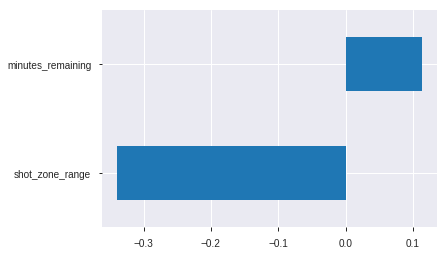

In [42]:
# Plot logistic regression coefficients.
%matplotlib inline
coefs = pd.Series(lr_model.coef_[0], X_train_encoded.columns)
coefs.sort_values().plot.barh();

#### 5. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [0]:
# Store data from confusion matrix.
true_positives = 36
false_positives = 58
true_negatives = 85
false_negatives = 8

In [44]:
# Calculate and display accuracy.
accurate_predictions = true_positives + true_negatives
inaccurate_predictions = false_positives + false_negatives
total_predictions = accurate_predictions + inaccurate_predictions
print('Accuracy:', accurate_predictions / total_predictions)

Accuracy: 0.6470588235294118


In [45]:
# Calculate and display balanced accuracy.
total_positive_cases = true_positives + false_negatives
total_negative_cases = true_negatives + false_positives

true_positive_rate = true_positives / total_positive_cases
true_negative_rate = true_negatives / total_negative_cases

print('Balanced Accuracy:', (true_positive_rate + true_negative_rate)/2)

Balanced Accuracy: 0.7062937062937062


In [46]:
# Calculate and display precision.
total_positive_predictions = true_positives + false_positives
precision = true_positives / total_positive_predictions
print('Precision:', precision)

Precision: 0.3829787234042553


In [47]:
# Calculate and display recall.
recall = true_positives / total_positive_cases
print('Recall:', recall)

Recall: 0.8181818181818182


### Stretch goals

#### 1. Calculate F1 score for the provided, imaginary confusion matrix

In [48]:
# Calculate and display F1 score.
print('F1 score:', 2*(precision*recall)/(precision+recall))

F1 score: 0.5217391304347826


#### 2. Plot a real confusion matrix for your basketball model, with row and column labels

In [49]:
# Generate and print confusion matrix.
cm = confusion_matrix(y_val, y_val_pred_lr)
cm

array([[457, 146],
       [357, 208]])

In [50]:
# Create and preview automated labels for confusion matrix.
columns = [f'Predicted {c}' for c in unique_labels(y_val_pred_lr)]
index_names = [f'Actual {c}' for c in unique_labels(y_val)]
columns, index_names

(['Predicted 0', 'Predicted 1'], ['Actual 0', 'Actual 1'])

In [0]:
# Create more human-friendly confusion matrix labels instead.
columns = ['Predicted failure', 'Predicted success']
index_names = ['Actual failure', 'Actual success']

In [52]:
# Label and re-print confusion matrix.
cm_df = pd.DataFrame(cm, columns=columns, index=index_names)
cm_df

,Predicted failure,Predicted success
Actual failure,457,146
Actual success,357,208


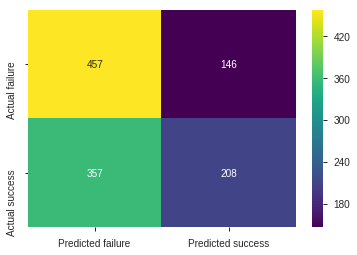

In [53]:
# Re-display confusion matrix as heatmap.
sns.heatmap(cm_df, cmap='viridis', annot=True, fmt='d');

In [54]:
# Check confusion matrix numbers.
pd.DataFrame(str(x) + ' ' + \
             str(y) for x, y in zip(y_val, y_val_pred_lr))[0].value_counts()

0 0    457
1 0    357
1 1    208
0 1    146
Name: 0, dtype: int64

#### 3. Print the classification report for your model

In [55]:
# Print classification report for simple logistic regression model.
print(classification_report(y_val, y_val_pred_lr))

              precision    recall  f1-score   support

           0       0.56      0.76      0.65       603
           1       0.59      0.37      0.45       565

    accuracy                           0.57      1168
   macro avg       0.57      0.56      0.55      1168
weighted avg       0.57      0.57      0.55      1168

